In [1]:
import copy
import os
import random
import time

import cv2
import kornia.augmentation as K
import kornia.enhance as E
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


/home/sid/git/venv/venv/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [2]:
df = pd.read_csv("gicsd_labels.csv", skipinitialspace=True)
df.LABEL = df.LABEL.str.strip()
df["IMG_PATH"] = os.path.join(os.getcwd(), "images/") + df.IMAGE_FILENAME 
print(df.head())
full_vis = df[df["LABEL"] == "FULL_VISIBILITY"]
part_vis = df[df["LABEL"] == "PARTIAL_VISIBILITY"]
no_vis = df[df["LABEL"] == "NO_VISIBILITY"]
print(len(full_vis), len(part_vis), len(no_vis))
assert  len(full_vis)+ len(part_vis)+ len(no_vis) == 800

     IMAGE_FILENAME               LABEL  \
0   GICSD_1_0_3.png     FULL_VISIBILITY   
1  GICSD_1_0_13.png     FULL_VISIBILITY   
2  GICSD_1_1_33.png  PARTIAL_VISIBILITY   
3  GICSD_1_1_53.png     FULL_VISIBILITY   
4  GICSD_1_2_73.png     FULL_VISIBILITY   

                                        IMG_PATH  
0   /home/sid/git/ml_task/images/GICSD_1_0_3.png  
1  /home/sid/git/ml_task/images/GICSD_1_0_13.png  
2  /home/sid/git/ml_task/images/GICSD_1_1_33.png  
3  /home/sid/git/ml_task/images/GICSD_1_1_53.png  
4  /home/sid/git/ml_task/images/GICSD_1_2_73.png  
646 123 31


In [3]:
full_vis_dict = {}
for row in full_vis.iterrows(): 
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"] 
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  full_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

part_vis_dict = {}
for row in part_vis.iterrows():
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"]
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  part_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

no_vis_dict = {}
for row in no_vis.iterrows():
  path = row[1]["IMG_PATH"]
  name = row[1]["IMAGE_FILENAME"]
  bgr = cv2.imread(path)
  rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
  no_vis_dict[name] = (rgb, bgr, gray)
  #print(np.min(gray), np.max(gray))

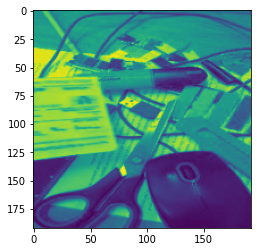

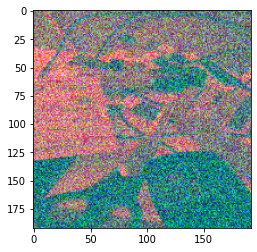

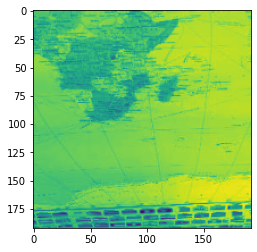

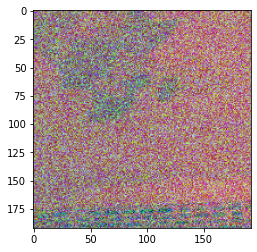

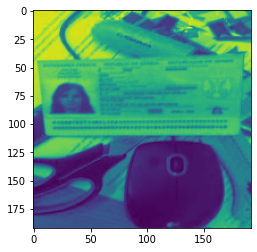

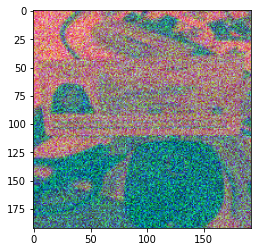

In [4]:


key = random.choice(list(part_vis_dict))
rgb, bgr, gray = part_vis_dict[key]

plt.imshow(bgr[:,:,0])
plt.show()

plt.imshow(bgr)
plt.show()

key = random.choice(list(no_vis_dict))
rgb, bgr, gray = no_vis_dict[key]
plt.imshow(bgr[:,:,0])
plt.show()


plt.imshow(bgr)
plt.show()

key = random.choice(list(full_vis_dict))
rgb, bgr, gray = full_vis_dict[key]

plt.imshow(bgr[:,:,0])
plt.show()

plt.imshow(bgr)
plt.show()


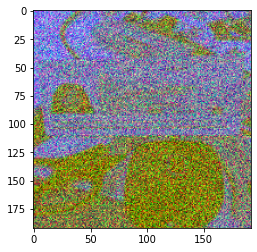

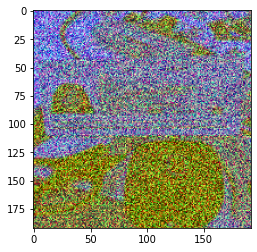

In [5]:
# taking the previouslty generated rgb image and running it through CLAHE we can see the contrast improvement
# this will enhance the contrast between the ID and background and help in classification with noisy image

rgb = rgb.reshape(192, 192, 3)

plt.imshow(rgb)
plt.show()
image = Image.fromarray(rgb).convert('RGB')
aug = A.Compose({
        A.CLAHE(1.0,(8,8)),
        })
image = aug(image=np.array(image))['image']
plt.imshow(image)

In [6]:
df_copy = df.copy()

Y = df_copy.pop("LABEL").to_frame()
X = df_copy

# stratified splitting the data to 74% train, 13% val and 13% test for maintaing class imbalance
x_train, x_test, y_train, y_test  = train_test_split(X, Y, random_state=7, stratify=Y, test_size=0.26)
x_test, x_val, y_test, y_val  = train_test_split(x_test, y_test, random_state=7, stratify=y_test, test_size=0.5)

print(len(x_train), len(y_train) ,len(x_test), len(y_test), len(x_val), len(y_val))

print((y_train.LABEL.value_counts()/y_train.LABEL.count())*100)
print((y_test.LABEL.value_counts()/y_test.LABEL.count())*100)
print((y_val.LABEL.value_counts()/y_val.LABEL.count())*100)


592 592 104 104 104 104
FULL_VISIBILITY       80.743243
PARTIAL_VISIBILITY    15.371622
NO_VISIBILITY          3.885135
Name: LABEL, dtype: float64
FULL_VISIBILITY       80.769231
PARTIAL_VISIBILITY    15.384615
NO_VISIBILITY          3.846154
Name: LABEL, dtype: float64
FULL_VISIBILITY       80.769231
PARTIAL_VISIBILITY    15.384615
NO_VISIBILITY          3.846154
Name: LABEL, dtype: float64


In [7]:
print(y_train.LABEL.value_counts())
weights = [646/646, 646/123, 646/31]  #based on overall distribution
weights

FULL_VISIBILITY       478
PARTIAL_VISIBILITY     91
NO_VISIBILITY          23
Name: LABEL, dtype: int64


[1.0, 5.252032520325203, 20.838709677419356]

In [8]:
class CustomImageDataset(Dataset):
    
    def __init__(self, x_df, y_df, transform):
        self.x = x_df.IMG_PATH.to_list()
        self.y = y_df.LABEL.to_list()
        self.transform = transform
        self.class_map = {"FULL_VISIBILITY" : 0,
                          "PARTIAL_VISIBILITY": 1,
                          "NO_VISIBILITY": 2,
                          }
         
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        #img = Image.open(self.x[idx]).convert("RGB")   
        
        img = cv2.imread(self.x[idx])
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                 
        if self.transform is not None:
            img = self.transform(image=np.array(img))["image"]
            
        class_name = self.y[idx] 
        class_id = self.class_map[class_name]
        class_id = torch.tensor([class_id])
        
        return img, class_id
    
data_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CLAHE(1.0,(8,8)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224), 
        A.CLAHE(1.0,(8,8)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(), 
    ]),
    'test': A.Compose([
        A.Resize(224, 224), 
        A.CLAHE(1.0,(8,8)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(), 
    ])
}

x_df = {'train': x_train, 'val': x_val, 'test': x_test}
y_df = {'train': y_train, 'val': y_val, 'test': y_test}

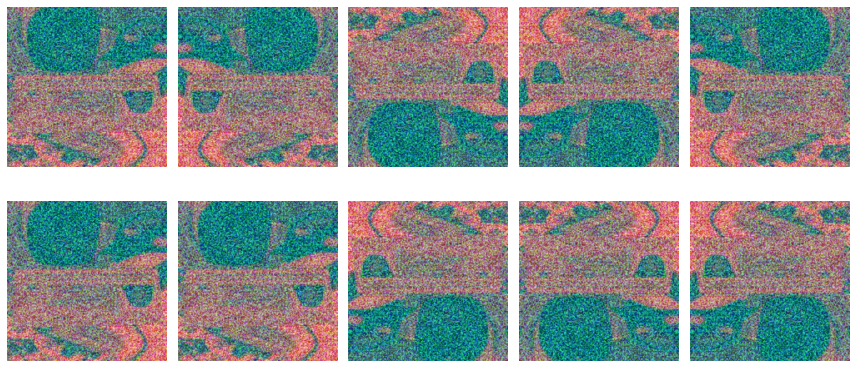

In [9]:

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
random.seed(42)
visualize_augmentations(CustomImageDataset(x_df["train"], y_df["train"], data_transforms["train"]))

In [10]:
dataloaders = { split : DataLoader(
                            CustomImageDataset(x_df[split], y_df[split], data_transforms[split]), 
                            batch_size = 64,
                            num_workers = 4)
                for split in ['train', 'val', 'test']}

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.reshape(inputs.shape[0])
                #print(labels, labels.shape)
                #print(inputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate losss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    #if phase == "val":
                    #    print(preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

# we have 3 output classes
model_ft.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.Tensor(weights).to(device))

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.025 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.025)

#print(model_ft)

512


In [13]:


num_epochs=200
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/199
----------
train Loss: 1.4444 Acc: 0.3345
val Loss: 1.1165 Acc: 0.0385

Epoch 1/199
----------
train Loss: 1.2988 Acc: 0.4122
val Loss: 1.1006 Acc: 0.8077

Epoch 2/199
----------
train Loss: 1.2112 Acc: 0.3801
val Loss: 1.1033 Acc: 0.1538

Epoch 3/199
----------
train Loss: 1.2617 Acc: 0.2872
val Loss: 1.1401 Acc: 0.0385

Epoch 4/199
----------
train Loss: 1.2150 Acc: 0.3497
val Loss: 1.1492 Acc: 0.1538

Epoch 5/199
----------
train Loss: 1.1219 Acc: 0.3125
val Loss: 1.1411 Acc: 0.1538

Epoch 6/199
----------
train Loss: 1.1671 Acc: 0.3041
val Loss: 1.1052 Acc: 0.8077

Epoch 7/199
----------
train Loss: 1.1509 Acc: 0.4392
val Loss: 1.1796 Acc: 0.0385

Epoch 8/199
----------
train Loss: 1.1337 Acc: 0.3784
val Loss: 1.1335 Acc: 0.8077

Epoch 9/199
----------
train Loss: 1.1086 Acc: 0.3615
val Loss: 1.1340 Acc: 0.8077

Epoch 10/199
----------
train Loss: 1.1347 Acc: 0.2736
val Loss: 1.1821 Acc: 0.1538

Epoch 11/199
----------
train Loss: 1.1787 Acc: 0.2517
val Loss: 1.2259 Acc

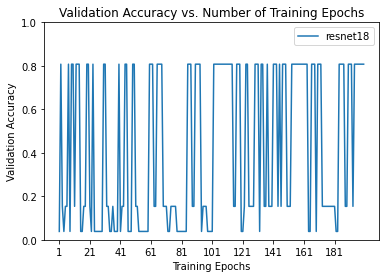

In [14]:

ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), ohist, label="resnet18")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 20))
plt.legend()
plt.show()

In [15]:

model_ft.eval()   # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0

for inputs, labels in dataloaders["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    labels = labels.reshape(inputs.shape[0])
    #print(labels, labels.shape)
    #print(inputs.shape)
    # zero the parameter gradients
    optimizer_ft.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        # Get model outputs and calculate loss
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

    # statistics
    print(labels.data, preds)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    
    
test_loss = running_loss / len(dataloaders["test"].dataset)
test_acc = running_corrects.double() / len(dataloaders["test"].dataset)

print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", test_loss, test_acc))

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0') tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
test Loss: 1.1006 Acc: 0.8077
